# INTRO.

This Notebook contains my winning solution for the [NFT Price Prediction Challenge](https://bitgrit.net/competition/17). Kudos to the Bitgrit team for bringing us such an amazing challenge in the Web 3.0 space.


# The Data

The data used are the official data set as given in the resources folder.

- The collections dataset
- The Collections Twitter Statistics
- The NFTS Train set
- The NFTS Test set
- The sample submission format

# Environment
As my local machine resources are limited, this notebook was run on kaggle kennel to leverage the free and available resources.

- CPU ONLY. No GPU is needed.

###### Install Catboost

Install and Setup Catboost - The catboost model was the main model used to perform trainig and prediction.

In [1]:
!pip install catboost

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import catboost
catboost.__version__

'1.1.1'

In [3]:
import sklearn
sklearn.__version__

'1.0.2'

###### Import required Libraries

Kaggle has preinstalled libraries hence we can import them directly without the need to reinstall them

In [4]:
import numpy as np # Numpy for numerical operations
import pandas as pd #Pandas for tabular operations
from catboost import CatBoostRegressor #Catboost for Modelling


import seaborn as sns # Seaborn for Plots
import matplotlib.pyplot as plt #Matplotlib for plots and visualizations
%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

###### Import dataset

Here, I import the dataset using the pandas library, remember to change path for yourself

In [5]:
train = pd.read_csv("/kaggle/input/NFT-Price-Prediction/nfts_train.csv")
collections = pd.read_csv("/kaggle/input/NFT-Price-Prediction/collections.csv").drop("Unnamed: 0", axis=1)
test = pd.read_csv("/kaggle/input/NFT-Price-Prediction/nfts_predict.csv")
sub = pd.read_csv("/kaggle/input/NFT-Price-Prediction/submission_format.csv")
twitter = pd.read_csv("/kaggle/input/NFT-Price-Prediction/collections_twitter_stats.csv").drop("Unnamed: 0", axis=1)

Check out the head of the train set to see what it looks like

In [6]:
train.tail(2)

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
309908,590226,8998,4,130.974464,NaN,NaN,NaN,2022-08,0.004236
309909,590227,8999,4,103.120966,NaN,NaN,NaN,2022-08,0.006236


Keep target _last sale price_ in a safe place to be used later during modelling

In [7]:
target = train.last_sale_price

train = train.drop("last_sale_price", axis=1)

Checkout the Tail of the test set

In [8]:
test.tail(2)

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date
181212,618140,7143,42,22134.000000,NaN,NaN,NaN,2021-04
181213,618141,7144,42,130.970414,NaN,NaN,NaN,2021-03


Check out what the collections look like

In [9]:
collections.head(2)

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium
0,19,1000,2021-04,verified,4,own,500.0,250,False,False,True,True,True
1,45,8888,2021-07,verified,5,own,500.0,250,False,False,True,True,False


Check out what the twitter data looks like

In [10]:
twitter.head(2)

,collection_id,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,0,2,183.000,8.5000,41.0000,123,3,6,243,14,76
1,1,16,36.375,3.5625,13.9375,0,0,0,125,21,34


A sneek peek into the highest occuring collection ID. It gives a sense of what kind of uniqueness we're expecting

In [11]:
train['collection_id'].mode()

0    46
dtype: int64

Describe the train data to see the important measures of tendency

In [12]:
train.describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank
count,309910.000000,309910.000000,309910.000000,309910.000000,80480.000000,80480.000000,80480.000000
mean,317003.207947,6738.162024,30.507160,1437.092531,1.000000,5630.164737,11255.829672
std,173138.765569,5977.542096,18.331668,4303.585892,0.152825,3812.126968,3452.713804
min,21928.000000,0.000000,0.000000,1.000000,0.626738,1.000000,5555.000000
25%,174892.250000,2453.000000,13.000000,106.587184,0.906820,2515.750000,9928.000000
50%,341467.500000,5138.000000,34.000000,170.797030,0.978289,5030.000000,10000.000000
75%,493626.750000,8720.750000,46.000000,289.614129,1.059866,8207.250000,15000.000000
max,590227.000000,29898.000000,60.000000,90354.072248,3.663833,15555.000000,15555.000000


###### Merge Train and test data

Rather than doing prepocessing twice or having to copy the same code for train and test set, Merge instead and split back after processing

In [13]:
data = pd.concat([train, test]).reset_index()

###### Intelligent Combinations

Combine both the twitter and collections data to the dataset. This helps build a more robust dataset, and helps the model understand the data better

In [14]:
data = data.merge(collections, how='left', on='collection_id')
data = data.merge(twitter, how='left', on='collection_id')

###### Extract date time features.

Extract the basic date time features from both the creation date and the Last sale date. The key data to extract are:

- Year
- Month

In [15]:
data["creation_date"] = pd.to_datetime(data.creation_date)
data['creation_date_year'] = data.creation_date.dt.year
data['creation_date_year'] = data.creation_date.dt.month



data["last_sale_date"] = pd.to_datetime(data.last_sale_date)
data['last_sale_date_year'] = data.last_sale_date.dt.year
data['last_sale_date_month'] = data.last_sale_date.dt.month

###### Engineer more Features.

Here I engineer some features. 

1. The first is to take the length of days between the creation date and the last sale date.
2. The second feature gives a score of rows that have all the mentioned communications medium: this includes if they have website, twitter, discord and medium and if openrarity is enabled. With this I give a score "1 point" for each medium


In [16]:
data['diff_days'] = (pd.to_datetime(data["last_sale_date"]) - pd.to_datetime(data['creation_date'])).dt.days

In [17]:
data["has_all"] = data.select_dtypes(include=["bool_"]).T.sum()

###### More Cleaning and manipulation.

Here I map the booleans in the data set, scoring them "1" if true and "0" if False. They include.

- Openrarity enabled
- has website
- has own twitter
- has discord
- has medium

In [18]:
data_bool = data.select_dtypes(include=["bool_"]).columns.tolist()
data_bool

['openrarity_enabled',
 'has_website',
 'has_own_twitter',
 'has_discord',
 'has_medium']

In [19]:
for i in data_bool:
  data[i] = data[i].map({True:1, False:0})

For the verification status, I score them based on a simple mapping. For Approved ones, I score them "1", for the verified ones, I score them "3". If they are neither approved nor verified, I give a "0" score

In [20]:
data.verification_status.unique()
v_stat = []

for i in data.verification_status:
  if i ==  'approved':
    v_stat.append(1)
  elif i ==  'verified':
    v_stat.append(3)
  else:
    v_stat.append(0)

data.verification_status = v_stat

For the contract type, the mapping is simple. For **default** replace with "0", for **own** replace with "1" 

In [21]:
data.contract_type.unique()
data["contract_type"] = data["contract_type"].map({"default":0, "own":1})

Drop both the **last sale date** and **creation date**, we've extracted the required features from them

In [22]:
data = data.drop(columns = ["last_sale_date", "creation_date"], axis=1)

quick peek at what the contract type raw data looks like

In [23]:
data["contract_type"]

0         1
1         1
2         1
3         1
4         1
         ..
491119    0
491120    0
491121    0
491122    0
491123    0
Name: contract_type, Length: 491124, dtype: int64

In [24]:
test.shape, train.shape # Check out the true train and test shape

((181214, 8), (309910, 8))

In [25]:
data.info() # view data info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491124 entries, 0 to 491123
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 491124 non-null  int64  
 1   global_index          491124 non-null  int64  
 2   nft_id                491124 non-null  int64  
 3   collection_id         491124 non-null  int64  
 4   rarity_score          491124 non-null  float64
 5   openrarity_score      119106 non-null  float64
 6   openrarity_rank       119106 non-null  float64
 7   openrarity_max_rank   119106 non-null  float64
 8   total_supply          491124 non-null  int64  
 9   verification_status   491124 non-null  int64  
 10  n_of_traits           491124 non-null  int64  
 11  contract_type         491124 non-null  int64  
 12  seller_fees           458431 non-null  float64
 13  platform_fees         491124 non-null  int64  
 14  openrarity_enabled    491124 non-null  int64  
 15  

In [26]:
data = data.drop(columns = ["index"])

In [27]:
data.iloc[0:,20:]

,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,creation_date_year,last_sale_date_year,last_sale_date_month,diff_days,has_all
0,8.290323,60.935484,0,0,2,591,28,380,4,2022,11,214,2
1,13.454545,55.181818,0,0,7,402,47,239,7,2021,8,31,2
2,13.454545,55.181818,0,0,7,402,47,239,7,2022,8,396,2
3,13.454545,55.181818,0,0,7,402,47,239,7,2021,8,31,2
4,13.454545,55.181818,0,0,7,402,47,239,7,2022,9,427,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491119,0.302395,0.314371,0,0,0,80,6,13,1,2021,4,90,3
491120,0.302395,0.314371,0,0,0,80,6,13,1,2021,4,90,3
491121,0.302395,0.314371,0,0,0,80,6,13,1,2021,4,90,3
491122,0.302395,0.314371,0,0,0,80,6,13,1,2021,4,90,3


###### Even More Engineering.

Create Statistical Features for some specific columns.

- Rarity score.
- Total Supply.
- Number of traits.
- Seller Fees.
- Platform Fees.

In [28]:
data_nft_stats = data.groupby("nft_id").agg(
             nft_rarity_score_min = ('rarity_score', 'min'),
             nft_rarity_score_max = ('rarity_score', 'max'),
             nft_rarity_score_mean = ('rarity_score', 'mean'), 
             nft_rarity_score_sum = ('rarity_score', 'sum'),
             nft_rarity_score_std = ('rarity_score', 'std'),
             nft_rarity_score_median = ('rarity_score', 'median'), 

             nft_total_supply_min = ('total_supply', 'min'),
             nft_total_supply_max = ('total_supply', 'max'),
             nft_total_supply_mean = ('total_supply', 'mean'), 
             nft_total_supply_sum = ('total_supply', 'sum'),
             nft_total_supply_std = ('total_supply', 'std'),
             nft_total_supply_median = ('total_supply', 'median'), 

             nft_n_of_traits_min = ('n_of_traits', 'min'),
             nft_n_of_traits_max = ('n_of_traits', 'max'),
             nft_n_of_traits_mean = ('n_of_traits', 'mean'), 
             nft_n_of_traits_sum = ('n_of_traits', 'sum'),
             nft_n_of_traits_std = ('n_of_traits', 'std'),
             nft_n_of_traits_median = ('n_of_traits', 'median'), 

             nft_seller_fees_min = ('seller_fees', 'min'),
             nft_seller_fees_max = ('seller_fees', 'max'),
             nft_seller_fees_mean = ('seller_fees', 'mean'), 
             nft_seller_fees_sum = ('seller_fees', 'sum'),
             nft_seller_fees_std = ('seller_fees', 'std'),
             nft_seller_fees_median = ('seller_fees', 'median'), 

             nft_platform_fees_min = ('platform_fees', 'min'),
             nft_platform_fees_max = ('platform_fees', 'max'),
             nft_platform_fees_mean = ('platform_fees', 'mean'), 
             nft_platform_fees_sum = ('platform_fees', 'sum'),
             nft_platform_fees_std = ('platform_fees', 'std'),
             nft_platform_fees_median = ('platform_fees', 'median'), 
).reset_index()

In [29]:
data_nft_stats.head() #peek at the head

,nft_id,nft_rarity_score_min,nft_rarity_score_max,nft_rarity_score_mean,nft_rarity_score_sum,nft_rarity_score_std,nft_rarity_score_median,nft_total_supply_min,nft_total_supply_max,nft_total_supply_mean,...,nft_seller_fees_mean,nft_seller_fees_sum,nft_seller_fees_std,nft_seller_fees_median,nft_platform_fees_min,nft_platform_fees_max,nft_platform_fees_mean,nft_platform_fees_sum,nft_platform_fees_std,nft_platform_fees_median
0,0,0.0,25823.0,1049.762075,50388.579586,4218.771691,165.291944,1,58351,10760.979167,...,711.956522,32750.0,243.626486,750.0,250,250,250.0,12000,0.0,250.0
1,1,0.0,44268.0,1419.008385,66693.394077,6666.314548,171.000704,420,58351,10989.914894,...,705.555556,31750.0,242.436079,750.0,250,250,250.0,11750,0.0,250.0
2,2,0.0,25823.0,1016.603321,47780.356096,4082.520067,143.146201,420,58351,10989.914894,...,705.555556,31750.0,242.436079,750.0,250,250,250.0,11750,0.0,250.0
3,3,0.0,25823.0,1139.553739,53559.025727,4523.964696,170.658647,420,58351,10989.914894,...,705.555556,31750.0,242.436079,750.0,250,250,250.0,11750,0.0,250.0
4,4,0.0,25823.0,1032.623820,48533.319518,4110.028066,179.395901,420,58351,10989.914894,...,705.555556,31750.0,242.436079,750.0,250,250,250.0,11750,0.0,250.0


In [30]:
data = data.merge(data_nft_stats, how='left', on='nft_id') #combine new features to the dataset

In [31]:
data.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,verification_status,n_of_traits,...,nft_seller_fees_mean,nft_seller_fees_sum,nft_seller_fees_std,nft_seller_fees_median,nft_platform_fees_min,nft_platform_fees_max,nft_platform_fees_mean,nft_platform_fees_sum,nft_platform_fees_std,nft_platform_fees_median
0,21928,0,49,2.000000,NaN,NaN,NaN,1,3,2,...,711.956522,32750.0,243.626486,750.0,250,250,250.0,12000,0.0,250.0
1,32621,0,45,97.077216,NaN,NaN,NaN,8888,3,5,...,711.956522,32750.0,243.626486,750.0,250,250,250.0,12000,0.0,250.0
2,32622,1,45,139.453086,NaN,NaN,NaN,8888,3,5,...,705.555556,31750.0,242.436079,750.0,250,250,250.0,11750,0.0,250.0
3,32623,2,45,127.753445,NaN,NaN,NaN,8888,3,5,...,705.555556,31750.0,242.436079,750.0,250,250,250.0,11750,0.0,250.0
4,32624,3,45,112.315719,NaN,NaN,NaN,8888,3,5,...,705.555556,31750.0,242.436079,750.0,250,250,250.0,11750,0.0,250.0


###### Settling

Split back the train and test dataset.

In [32]:
# Separate train and test data from the combined dataframe
df_train = data[:train.shape[0]]
df_test = data[train.shape[0]:]

X = df_train
y = target

# Check the shapes of the split dataset
df_train.shape, df_test.shape

((309910, 63), (181214, 63))

###### Quick Insight.

Just before training, I checked out the skewed nature of the target variable. I also apply a logarithmic transformation and visualize both side by side

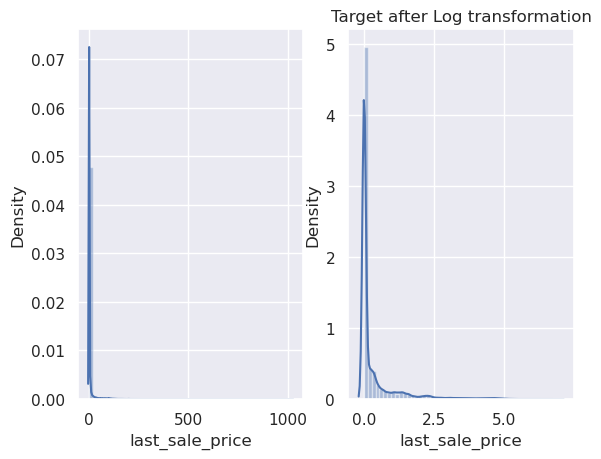

In [33]:
sns.set()
y=target
y_transformed = pd.Series(np.log1p(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])

plt.title("Target after Log transformation")

sns.distplot(y_transformed, ax=ax[1])
plt.show()

###### Training.

Import the required libraries needed, you can also move all imports to the top, depending on your preference.

What's going on here?

This is where I perform traing and inference. I utilize the Catboost model after testing several other models. I also pass in my hyperparameters after testing several bunch of parameters. Finally, I create a 16 fold cross validation split where i train on the transformed label and undo the transformation after inference to get back the truth.

At the end, I take the mean of my predictions and push for a submission. This bagged me my highest Public score of 0.9367.

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

In [35]:
fold_pred=[]   # a list where I keep out of fold predictions
oof_pred = []  # a list where I keep track of the scores per fold.




# Set Hyperparameters.

params = {
 'learning_rate': 0.163251453473545997,
 'max_depth': 14,
 'subsample': 0.6530887571489526}


# Create a Kfold with 16 splits. Set the random state to 2023.

fold= KFold(n_splits=16, shuffle=True, random_state = 2023)
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = CatBoostRegressor(**params)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.expm1(preds)))**0.5)  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds))**0.5)
    p2 = model.predict(df_test[X.columns])
    fold_pred.append(np.expm1(p2))
    

print(np.mean(oof_pred))

err:  8.98539993729327
err:  8.899906991165546
err:  8.424553107727748
err:  7.063790895382252
err:  9.695621703221061
err:  9.383757927317381
err:  11.220961542785828
err:  8.888607720161785
err:  11.07442194763054
err:  7.339152477567926
err:  6.792567597817056
err:  9.557306255624537
err:  7.967178271575981
err:  9.776802529430041
err:  7.77844475827965
err:  7.128816483522865
8.748580634156466


######  Feature Importance Plot.

Here I plot the feature importance to understand how the model has learnt about the data. This also informed my decision on some of the columns I created statistical features for.

Text(0.5, 1.0, 'CatboostRegressor features importance (top 50):')

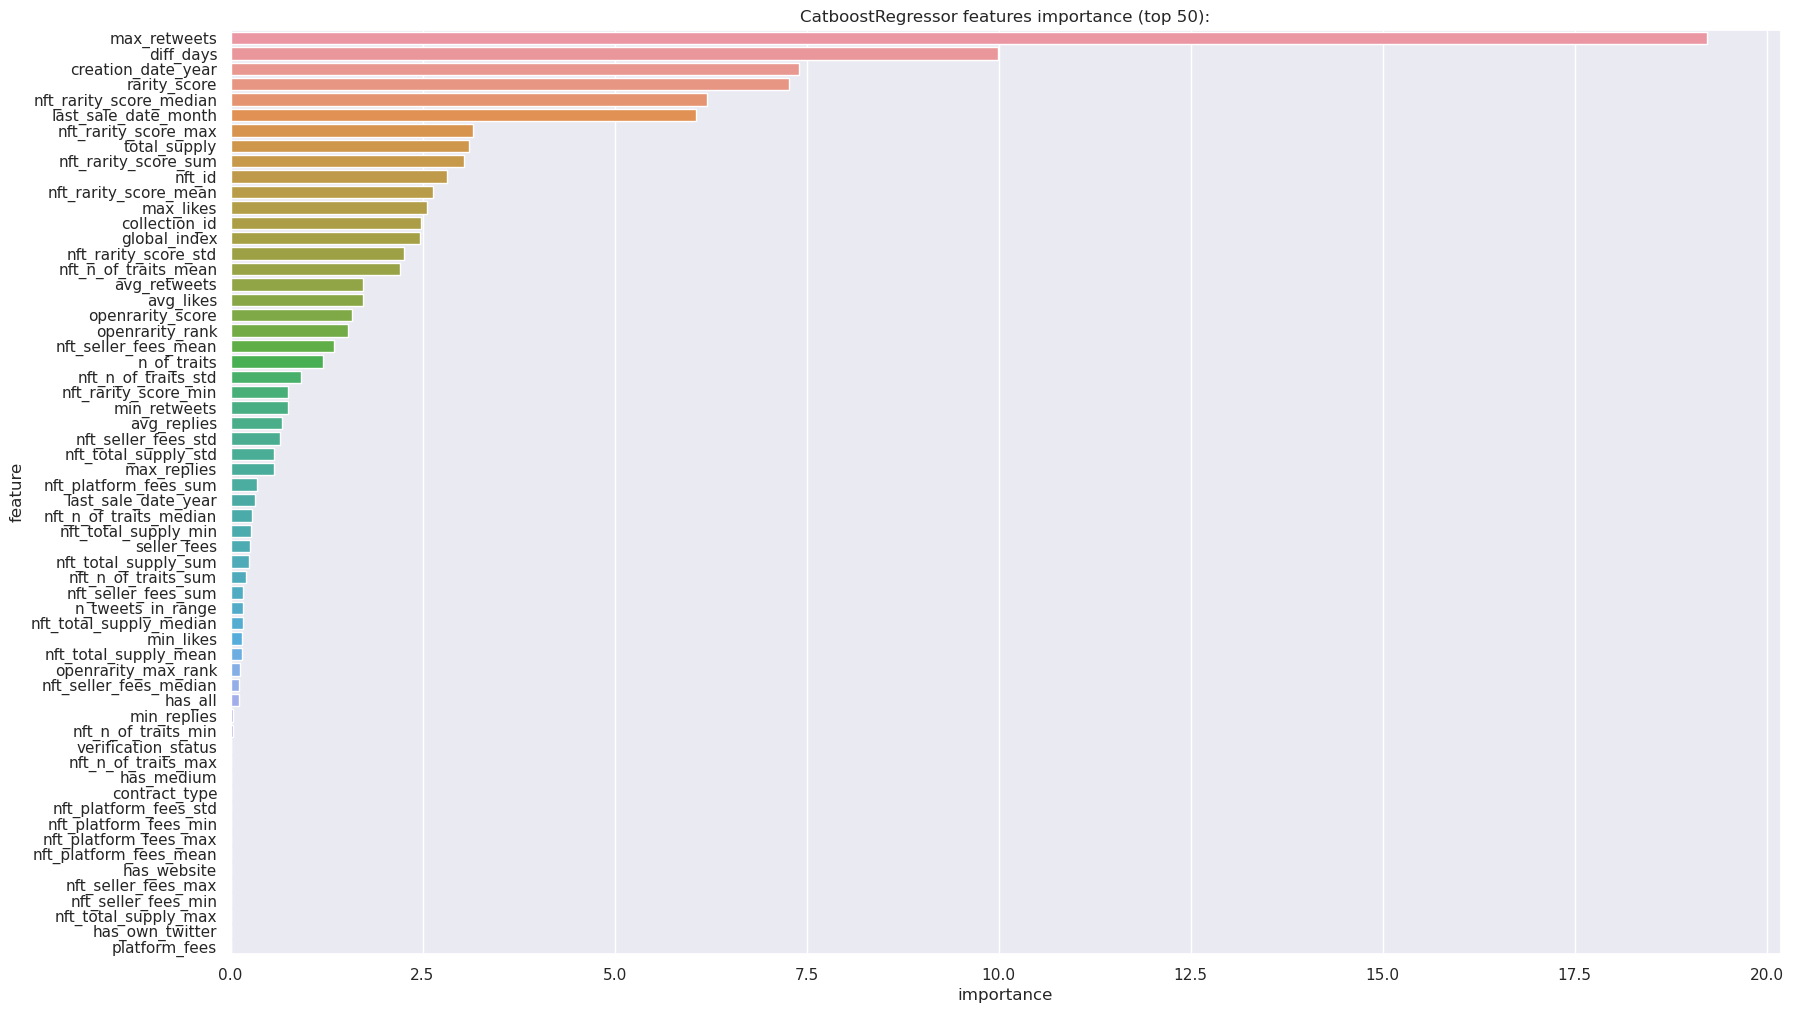

In [36]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostRegressor features importance (top 50):')

Create the A submission like the Sample submission and submit.

In [37]:
sub #my sample submission

sub2 = pd.DataFrame()
sub2["global_index"] = df_test.global_index
sub2["last_sale_price"] = np.mean(fold_pred, axis = 0) # Take mean of folded predictions.

In [38]:
sub2 = sub2.reset_index(drop=True)

In [39]:
# Write to csv file to submit to BitGrit
name = "Catboost_Reproducibility.csv"
sub2.to_csv(name, index = False)

With This I was able to bag a score of 0.9367 on the Public leader board and 0.940 on the Private leaderboard hence coming first in both places.

Thanks for reviewing my solution and for hosting such a wonderful hackathon. I am always open to conversations and talks centered around Machine learning and Deep learning. Please Feel free to reach out to me anytime.

. [Twitter](https://twitter.com/Osinkoluolufemi).

. [Linkedin](https://www.linkedin.com/in/olufemi-victor-tolulope).

. [Github](https://github.com/osinkolu)

. [Email](mailto:femiosinkolu@gmail.com)

### Author: Olufemi Victor Tolulope